# Performing Ground State Estimation (GSE) for $H_2$ using pyLIQTR
<h2> Distribution Statement </h2>

DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

<br>
This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

<br>
© 2022 Massachusetts Institute of Technology.

<br>
<br>
The software/firmware is provided to you on an As-Is basis

<br>
<br>
Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

In [1]:
from pyLIQTR.GSE.GSE  import GSE 

from openfermion.chem import MolecularData
from cirq.contrib.svg import SVGCircuit

import numpy             as np
import matplotlib.pyplot as plt

<b>Note:</b> To demonstrate how to generate a GSE circuit to calculate the properties of the $H_2$ molecule using <i>pyLIQTR</i>, we will load a pre-generated molecular hamiltonian using openfermion. The cell below demonstrates how to do so.

In [2]:
### 
### Define the file that holds the molecular hamiltoninan
###
file_name = 'H2_Molecule.hdf5'

molecule = MolecularData(filename=file_name)

###
### Load the molecule:
###
molecule.load()

###
### Get the molecular hamiltonian, which is an openfermion object
###
mol_ham = molecule.get_molecular_hamiltonian()

###
### Output some information to the screen:
###
print(f'> GS energy   = {molecule.hf_energy}')
print(f'> n electrons = {molecule.n_electrons}')
print(f'> n orbitals  = {molecule.n_orbitals}')
print(f'> n qubits    = {mol_ham.n_qubits}')

> GS energy   = -1.116684387085341
> n electrons = 2
> n orbitals  = 2
> n qubits    = 4


Trotterization of the Hamiltonian for $H_2$ results in a $16x16$ matrix. This matrix can be diagonalized, and the resulting eigenvalues and eigenvectors can be exactly calculated, as is demonstrated in notebook 1b for GSE. The resulting eigenvalues, which correspond to estimated energies of the $H_2$ system, are shown in Figure 1.


<img src="H2_figs/H2_EnergyLevelDiagram.png" width="300">

<b>Fig 1:</b> The energy spectrum for the $H_2$ Hamiltonian after first-order Trotterization.

The eigenvalues correspond to eigenstates which can be expressed in a single-particle basis comprised of the following particle-hole states:

 - |0000>
 - |1000>, |0100>, |0010>, |0001>
 - |1100>, |1010>, |1001>, |0110>, |0101>, |0011>
 - |0111>, |1011>, |1101>, |1110>
 - |1111>

 Some of the eigenvalues correspond to single-particle states, e.g., 0.813 and |0000>. However, most of the eigenvalues correspond to a linear combination of the single-particle basis states above.

 In what follows we use the GSE algorithm to examine two candidate states, |0000> and |1100>. The |0000> state is interesting due to its single-particle nature. The performance of the GSE algorithm is straight-forward. The second is interesting due to the fact that the corresponding eigenstate is a linear combination of the |1100> and |0011> single-particle basis states. This has important implications in how we interpret the simulation data. The GSE algorithm will collapse into the |1100> and |0011> states with a probability derived from the linear combination of the two basis states, and as such, this must be taken into account when analyzing the results.

## The |0000> candidate state

In [3]:
###
### Perform the simulation and estimate the energies
### for state |0000> which has an associated energy 
### of ~0.813
###

###
### There are a number of parameters that a user can 
### modify that will impact the resulting GSE circuit
### They are discussed below.
###

###
### The trotter order and trotter steps determine 
### how the user wants to estimate the Hamiltonian.
### Higher values will generally result in a more 
### accurateestimation of the Hamiltonian, but will 
### also generate a longer circuit.
### 
### The precision_order determines how many precision
### bits the user wants to measure. The higher the 
### value the longer the circuit.
###
trotter_order   = 1
trotter_steps   = 1
precision_order = 4

###
### The E_max and E_min values determine the energy
### interval for the measurement. These values have 
### a small impact on circuit length, but are critical
### for getting a correct measurement from the simulation
###
### Similarly, the initial state is important for 
### interpretting the output of the simulation ,but will
### only have a minimal impact on length of the circuit.
### 
E_max           = 2.0
E_min           = -2.0
init_state    = [0,0,0,0]


###
### Generating the circuit:
###
H2_kwargs = {
    'trotterize' : True,
    'mol_ham'    : mol_ham,
    'ev_time'    : 1,
    'trot_ord'   : trotter_order,
    'trot_num'   : trotter_steps
}

gse_inst = GSE(
    precision_order=precision_order,
    init_state=init_state,
    E_max = E_max,
    E_min = E_min,
    include_classical_bits=True,
    kwargs=H2_kwargs)

### Store the circuit for future visualization:
gse_circuit = gse_inst.pe_inst.pe_circuit

###
### Set the number of simulation
### runs, and perform the simulation:
###
gse_inst.num_runs = 50
gse_inst.do_GSE()

100%|██████████| 50/50 [00:12<00:00,  4.01it/s]


In [4]:
###
### To visualise the circuit, uncomment below 
### and execute this cell.
###

# SVGCircuit(gse_circuit)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [4]:
###
### Note: To determine if our simulations have the correct behavior, we 
###       need to use a known energy, translated to a known phase phi. 
###       This is done below.
###
actual_energy = 0.8126179630230763
actual_phi    = (E_max - actual_energy)/ (E_max - E_min)
diff_, prec_ = gse_inst.pe_simulator.sim_run_analysis(true_phase=actual_phi)

> -------- Sim Run Analysis Report --------
> There were a total of 50 runs.
> The required minimum precision was 0.0625 that 81.06% of runs need to meet.
> 94.00% of events meet precision threshold
>	This is in line with the 8/pi theory prediction :)
> The median measurement 0.3125 meets the precision threshold :)
>	 |0.3125 - 0.2968455092442309| = 0.01565449075576908


Text(0.5, 0, 'GSE Sim Run Number')

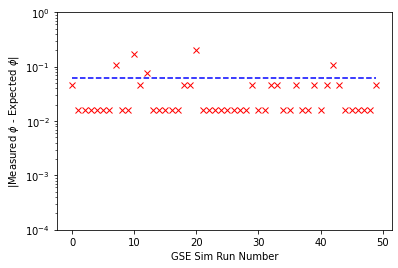

In [10]:
###
### Plot the differences between the real phase phi, and the 
### phi calculated during simulation runs.
###

plt.plot(diff_, 'rx')
plt.plot(np.ones(len(diff_))*prec_, 'b--')
plt.yscale('log')
plt.ylim([1e-4, 1])
plt.ylabel('|Measured $\phi$ - Expected $\phi$|')
plt.xlabel('GSE Sim Run Number')

## The |1100> Candidate State

In [11]:
###
### Perform the simulation and estimate the energies
### For state |1100> which has an associated energy 
### of ~-1.034 or ~0.574 due to degeneracy
###

###
### Again, there are a number of parameters that a user can 
### modify that will impact the resulting GSE circuit
### They are discussed below.
###

###
### The trotter order and trotter steps determine 
### how the user wants to estimate the Hamiltonian.
### Higher values will generally result in a more 
### accurateestimation of the Hamiltonian, but will 
### also generate a longer circuit.
### 
### The precision_order determines how many precision
### bits the user wants to measure. The higher the 
### value the longer the circuit.
###
trotter_order   = 1
trotter_steps   = 1
precision_order = 4

###
### The E_max and E_min values determine the energy
### interval for the measurement. These values have 
### a small impact on circuit length, but are critical
### for getting a correct measurement from the simulation
###
### Similarly, the initial state is important for 
### interpretting the output of the simulation ,but will
### only have a minimal impact on length of the circuit.
### 
E_max           = 2.0
E_min           = -2.0
init_state    = [1,1,0,0]


###
### Generating the circuit:
###
H2_kwargs = {
    'trotterize' : True,
    'mol_ham'    : mol_ham,
    'ev_time'    : 1,
    'trot_ord'   : trotter_order,
    'trot_num'   : trotter_steps
}

gse_inst = GSE(
    precision_order=precision_order,
    init_state=init_state,
    E_max = E_max,
    E_min = E_min,
    kwargs=H2_kwargs)

### Store the circuit for future visualization:
gse_circuit = gse_inst.pe_inst.pe_circuit

###
### Set the number of simulation
### runs, and perform the simulation:
###
gse_inst.num_runs = 100
gse_inst.do_GSE()

100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


In [12]:
###
### Again, we use the actual energy to determine 
### how the simulation is performing
###
actual_energy = -1.033994857387806
actual_phi    = (E_max - actual_energy)/ (E_max - E_min)
diff_, prec_ = gse_inst.pe_simulator.sim_run_analysis(true_phase=actual_phi)

> -------- Sim Run Analysis Report --------
> There were a total of 100 runs.
> The required minimum precision was 0.0625 that 81.06% of runs need to meet.
> 97.00% of events meet precision threshold
>	This is in line with the 8/pi theory prediction :)
> The median measurement 0.75 meets the precision threshold :)
>	 |0.75 - 0.7584987143469515| = 0.008498714346951486


Text(0.5, 0, 'GSE Sim Run Number')

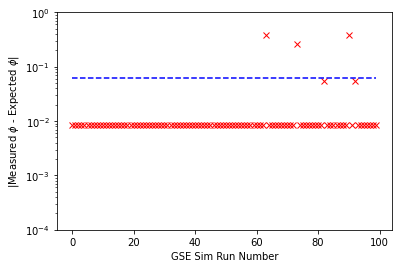

In [13]:
###
### And again we plot the differences between the real phase phi
### and the phi calculated during simulation runs.
###

plt.plot(diff_, 'rx')
plt.plot(np.ones(len(diff_))*prec_, 'b--')
plt.yscale('log')
plt.ylim([1e-4, 1])
plt.ylabel('|Measured $\phi$ - Expected $\phi$|')
plt.xlabel('GSE Sim Run Number')

At this point, your simulations of the GSE circuit for the |1100> candidate state may have yielded results that meet the required precision thresholds. However, if they have not, increasing the Trotter Number (which is the same as increasing the Trotter Steps), should help.

In [14]:
###
### Perform the simulation and estimate the energies
### For state |1100> which has an associated energy 
### of ~-1.034 or ~0.574 due to degeneracy
###
### Note: this took ~12 minutes to run on local machine
###

###
### Again, there are a number of parameters that a user can 
### modify that will impact the resulting GSE circuit
### They are discussed below.
###

###
### The trotter order and trotter steps determine 
### how the user wants to estimate the Hamiltonian.
### Higher values will generally result in a more 
### accurateestimation of the Hamiltonian, but will 
### also generate a longer circuit.
### 
### The precision_order determines how many precision
### bits the user wants to measure. The higher the 
### value the longer the circuit.
###
trotter_order   = 1
trotter_steps   = 5 # <-- increase to 5
precision_order = 4

###
### The E_max and E_min values determine the energy
### interval for the measurement. These values have 
### a small impact on circuit length, but are critical
### for getting a correct measurement from the simulation
###
### Similarly, the initial state is important for 
### interpretting the output of the simulation ,but will
### only have a minimal impact on length of the circuit.
### 
E_max           = 2.0
E_min           = -2.0
init_state    = [1,1,0,0]


###
### Generating the circuit:
###
H2_kwargs = {
    'trotterize' : True,
    'mol_ham'    : mol_ham,
    'ev_time'    : 1,
    'trot_ord'   : trotter_order,
    'trot_num'   : trotter_steps
}

gse_inst = GSE(
    precision_order=precision_order,
    init_state=init_state,
    E_max = E_max,
    E_min = E_min,
    kwargs=H2_kwargs)

### Store the circuit for future visualization:
gse_circuit = gse_inst.pe_inst.pe_circuit

###
### Set the number of simulation
### runs, and perform the simulation:
###
gse_inst.num_runs = 100
gse_inst.do_GSE()

100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


In [15]:
###
### Again, we use the actual energy to determine 
### how the simulation is performing
###
actual_energy = -1.033994857387806
actual_phi    = (E_max - actual_energy)/ (E_max - E_min)
diff_, prec_ = gse_inst.pe_simulator.sim_run_analysis(true_phase=actual_phi)

> -------- Sim Run Analysis Report --------
> There were a total of 100 runs.
> The required minimum precision was 0.0625 that 81.06% of runs need to meet.
> 90.00% of events meet precision threshold
>	This is in line with the 8/pi theory prediction :)
> The median measurement 0.75 meets the precision threshold :)
>	 |0.75 - 0.7584987143469515| = 0.008498714346951486


Text(0.5, 0, 'GSE Sim Run Number')

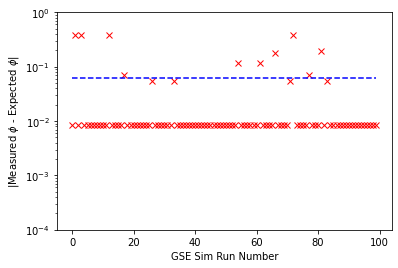

In [16]:
###
### And again we plot the differences between the real phase phi
### and the phi calculated during simulation runs.
###

plt.plot(diff_, 'rx')
plt.plot(np.ones(len(diff_))*prec_, 'b--')
plt.yscale('log')
plt.ylim([1e-4, 1])
plt.ylabel('|Measured $\phi$ - Expected $\phi$|')
plt.xlabel('GSE Sim Run Number')